In [1]:
%pip install pyextremes

  Obtaining dependency information for pyextremes from https://files.pythonhosted.org/packages/76/17/f6eb9f3208f94999fa92a019852de27dacee45fd377aac3ef7d576df691a/pyextremes-2.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for emcee<4.0.0,>=3.0.3 from https://files.pythonhosted.org/packages/f9/ef/2196b9bf88ffa1bde45853c72df021fbd07a8fa91a0f59a22d14a050dc04/emcee-3.1.6-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
   --------------------- ------------------ 30.7/57.6 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/47.4 kB ? eta -:--:--
   ---------------------------------------- 47.4/47.4 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import numpy as np
import pyextremes

data = yf.download("^GSPC", start="2008-01-01")['Close'] #S&P 500
log_returns = np.log(data / data.shift(1)).dropna()
print(data.shape)


[*********************100%***********************]  1 of 1 completed

(4378, 1)


<class 'pandas.core.frame.DataFrame'>


(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='Date', ylabel='^GSPC'>)

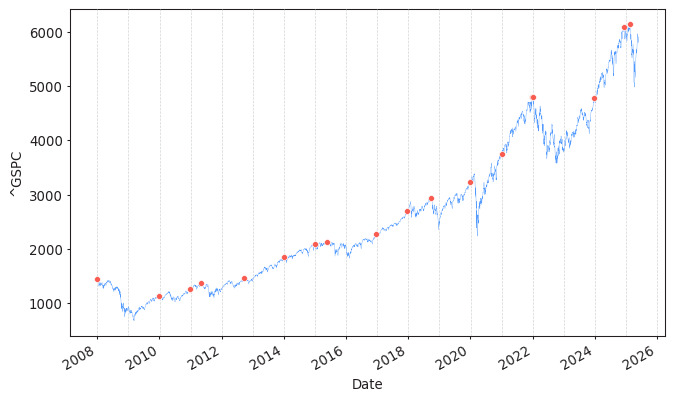

In [ ]:
losses = -log_returns[log_returns < 0] #negative returns values
threshold = np.quantile(losses, 0.95) #0.95th quantile from data, crude
extreme_values = losses[losses > threshold] - threshold

model = pyextremes.EVA(data=data['^GSPC'])
model.get_extremes("BM")
model.plot_extremes()
